<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse/blob/master/src/notebook/Apprentissage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est de predire la position et la hauteur d'un crenau sur la densite $\rho$, à partir de $E_r$ (energie des photons), $F_r$ (flux des photons), et $T_r$ (temperature du milieu) à droite du domaine en tout temps.

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import keras
from ast import literal_eval as l_eval

In [ ]:
from keras import layers
from keras import models
from keras import utils 
from keras import losses
from keras import metrics
from keras import optimizers

from keras import backend as K
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
np.set_printoptions(precision = 3)

# PREPARATION

## Chargement des données

In [ ]:
# """ VERSION COLAB """

# to load data from my personal github repo (update it if we have to)
import os
if not os.path.exists("assets"):
    print("Data wansn't here. Let's download it!")
    !git clone https://github.com/desmond-rn/assets.git
else:
    print("Data already here. Let's update it!")
    %cd assets
    !git pull https://github.com/desmond-rn/assets.git
    %cd ..

print("\n")
!ls assets/dataframes/inverse

df_t_path = "assets/dataframes/inverse/df_temporal.csv"
df_s_path = "assets/dataframes/inverse/df_spatial.csv"

df_t_base_path = "assets/dataframes/inverse/df_temporal"      # au cas ou les données sont cindées en parties
df_s_base_path = "assets/dataframes/inverse/df_spatial"

Data wansn't here. Let's download it!
Cloning into 'assets'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 295 (delta 7), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (295/295), 482.61 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (37/37), done.


df_rho.csv	      df_spatial_part5.csv   df_temporal_part4.csv
df_spatial.csv	      df_spatial_part6.csv   df_temporal_part5.csv
df_spatial_part1.csv  df_temporal.csv	     df_temporal_part6.csv
df_spatial_part2.csv  df_temporal_part1.csv  pickle
df_spatial_part3.csv  df_temporal_part2.csv
df_spatial_part4.csv  df_temporal_part3.csv


In [ ]:
# """ VERSION JUPYTER """

# # to load data locally

# %ls "../../data"

# df_t_path = "../../data/df_temporal.csv"
# df_s_path = "../../data/df_spatial.csv"

**Les données temporelles (qui contiennent les signaux $E_r$, $F_r$, et $T_r$)**

In [ ]:
# types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
# converters={'t':l_eval, 'E_l':l_eval, 'F_l':l_eval, 'T_l':l_eval, 'E_r':l_eval, 'F_r':l_eval, 'T_r':l_eval}      # on veut convertir les str en listes

# df_t = pd.read_csv(df_t_path, thousands=',', dtype=types, converters=converters)

# df_t.head(2)

In [ ]:
""" Fonction pour concatener des dataframes temporelles"""

def join_temporal_dataframes(*parts):
  assert len(parts) != 0

  types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
  converters={'t':l_eval, 'E_l':l_eval, 'F_l':l_eval, 'T_l':l_eval, 'E_r':l_eval, 'F_r':l_eval, 'T_r':l_eval}               # on veut convertir les str en listes

  df_t = pd.read_csv(df_t_base_path+"_"+parts[0]+".csv", thousands=',', dtype=types, converters=converters)

  for part in parts[1:]:
    tmp = pd.read_csv(df_t_base_path+"_"+part+".csv", thousands=',', dtype=types, converters=converters)
    
    df_t = pd.concat([df_t, tmp], ignore_index=True)

  return df_t 

In [ ]:
df_t = join_temporal_dataframes("part5", "part6")
# df_t = join_temporal_dataframes("part1", "part2", "part3", "part4")

df_t.head(2)

,x_min,x_max,N,c,a,C_v,CFL,precision,t_0,t_f,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_expr,T_0_expr,dt,step_count,t,E_l,F_l,T_l,E_r,F_r,T_r
0,0,1,300,299,0.01372,0.14361,0.99,0.000001,0,0.01,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000011,907,"[0, 1.10368e-05, 2.20736e-05, 3.31104e-05, 4.4...","[8.575, 8.575, 8.74508, 8.91742, 9.08948, 9.25...","[0, 0, 0.167339, 0.33685, 0.503506, 0.667603, ...","[5, 5, 5, 5.02419, 5.04876, 5.07296, 5.09649, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
1,0,1,300,299,0.01372,0.14361,0.99,0.000001,0,0.01,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000011,907,"[0, 1.10368e-05, 2.20736e-05, 3.31104e-05, 4.4...","[8.575, 8.575, 8.74508, 8.91742, 9.08948, 9.25...","[0, 0, 0.167339, 0.33685, 0.503506, 0.667603, ...","[5, 5, 5, 5.02419, 5.04876, 5.07296, 5.09649, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


**Les donnees spatiales (qui contiennent la densité $\rho$)**

In [ ]:
# types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
# converters={'x':l_eval, 'rho':l_eval, 'sigma_a':l_eval, 'sigma_c':l_eval, 'E_0':l_eval, 'F_0':l_eval, 'T_0':l_eval, 'E':l_eval, 'F':l_eval, 'T':l_eval}

# df_s = pd.read_csv(df_s_path, thousands=',', dtype=types, converters=converters)

# df_s.head(2)

In [ ]:
""" Fonction pour concatener des dataframes spatiales"""

def join_spatial_dataframes(*parts):
  assert len(parts) != 0

  types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
  converters={'x':l_eval, 'rho':l_eval, 'sigma_a':l_eval, 'sigma_c':l_eval, 'E_0':l_eval, 'F_0':l_eval, 'T_0':l_eval, 'E':l_eval, 'F':l_eval, 'T':l_eval}

  df_s = pd.read_csv(df_s_base_path+"_"+parts[0]+".csv", thousands=',', dtype=types, converters=converters)

  for part in parts[1:]:
    tmp = pd.read_csv(df_s_base_path+"_"+part+".csv", thousands=',', dtype=types, converters=converters)
    
    df_s = pd.concat([df_s, tmp], ignore_index=True)

  return df_s 

In [ ]:
df_s = join_spatial_dataframes("part5", "part6")
# df_s = join_spatial_dataframes("part1", "part2", "part3", "part4")

df_s.head(2)

,x_min,x_max,N,c,a,C_v,CFL,precision,t_0,t_f,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_expr,T_0_expr,dt,step_count,x,rho,sigma_a,sigma_c,E_0,F_0,T_0,E_f,F_f,T_f
0,0,1,300,299,0.01372,0.14361,0.99,0.000001,0,0.01,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000011,907,"[0.00166667, 0.005, 0.00833333, 0.0116667, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4.95968, 4.93456, 4.90985, 4.88565, 4.86211, ...","[4.95968, 4.93456, 4.90985, 4.88565, 4.86211, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[8.48207, 8.31198, 8.14616, 7.98535, 7.8302, 7...","[0.0645047, -0.113424, -0.288097, -0.458708, -...","[4.95968, 4.93456, 4.90985, 4.88565, 4.86211, ..."
1,0,1,300,299,0.01372,0.14361,0.99,0.000001,0,0.01,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000011,907,"[0.00166667, 0.005, 0.00833333, 0.0116667, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4.95437, 4.92843, 4.90289, 4.87788, 4.85355, ...","[4.95437, 4.92843, 4.90289, 4.87788, 4.85355, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[8.44227, 8.26747, 8.09714, 7.93202, 7.77281, ...","[0.103661, -0.0702006, -0.240991, -0.407924, -...","[4.95437, 4.92843, 4.90289, 4.87788, 4.85355, ..."


Nous impososns des préréquis pour cet apprentissage. Toutes les données doivent etre similaires sur un certain nombre de leurs paramètres.

In [ ]:
t_f = 0.01
x_min = 0
x_max = 1

for i in range(len(df_t)):
    # assert df_t.loc[i, 't_f'] == t_f
    assert df_t.loc[i, 'E_0_expr'] == "0.01372*(5^4)"
    # etc...
    assert df_t.loc[i, 'x_min'] == x_min
    assert df_t.loc[i, 'x_max'] == x_max

## Format binaire de sauvegarde

Par exemple, __*_phl_005__ signifie que la position(p), la hauteur(h) et la largeur(l) du saut de densité varient, et le temps final vaut 0.005

In [ ]:
""" Sauvegradons les dataframes sous forme binaire pickle """

# df_s.to_pickle('spatial_ph_01.pkl')      
# df_t.to_pickle('temporal_ph_01.pkl')

' Sauvegradons les dataframes sous forme binaire pickle '

In [ ]:
# df = pd.read_pickle('spatial_ph_01.pkl')

# len(df)

## Visualisation

In [ ]:
""" Visualisons les signaux sur la droite et la densite sur le domaine """

def plot_inputs(ax, df_t, index):
    t = np.array(df_t.loc[index, 't'])
    
    # inputs
    E_r = np.array(df_t.loc[index, 'E_r'])
    F_r = np.array(df_t.loc[index, 'F_r'])
    T_r = np.array(df_t.loc[index, 'T_r'])

    # plot 
    ax[0].plot(t, E_r, 'b', label='énergie à droite', lw=3)
    ax[0].set_ylim(8.52, 8.66)
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(t, F_r, 'y', label='flux à droite', lw=3)
    ax[1].set_ylim(-0.06, 0.063)
    ax[1].set_xlabel('t') 
    ax[1].legend()

    ax[2].plot(t, T_r, 'r', label='température à droite', lw=3)
    ax[2].set_ylim(4.9925, 5.0125)
    ax[2].set_xlabel('t')
    ax[2].legend()
    
def plot_output(ax, df_s, index):
    x = np.array(df_s.loc[index, 'x'])
    rho = np.array(df_s.loc[index, 'rho'])

    # plot 
    ax.plot(x, rho, 'm--', label='densité')
    ax.set_ylim(0.5, 10.5)
    ax.set_xlabel('x')
    ax.legend()

In [ ]:
def plot_io(index):
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    fig.delaxes(ax[1][0])
    fig.delaxes(ax[1][2])

    plot_inputs(ax[0], df_t, index)
    plot_output(ax[1, 1], df_s, index)
    plt.tight_layout()

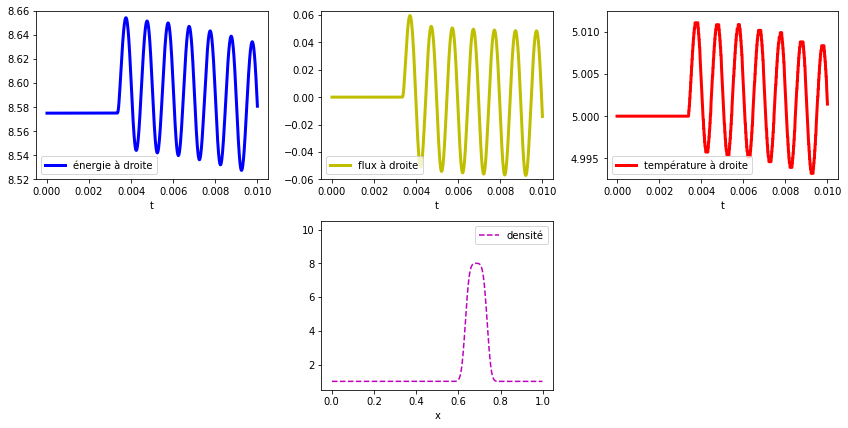

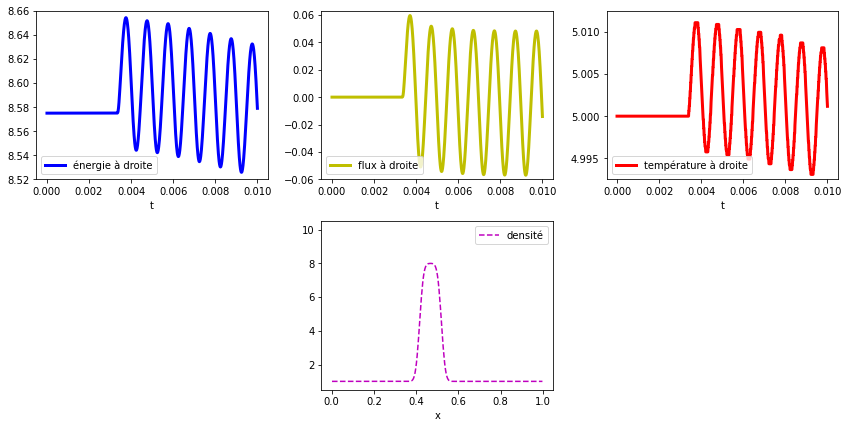

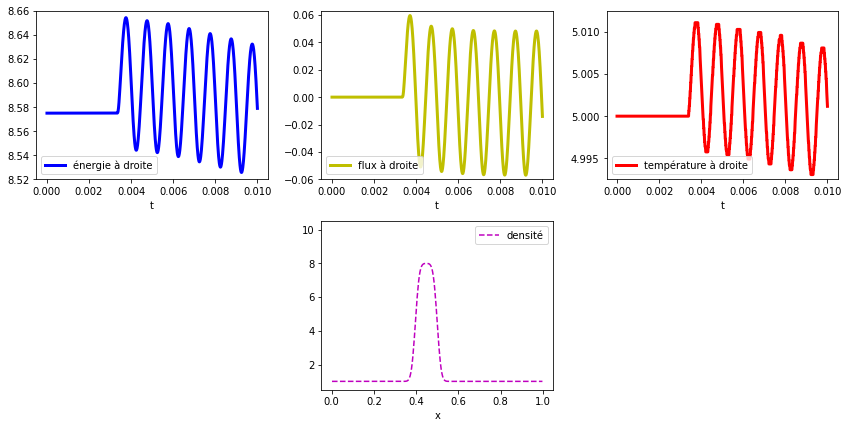

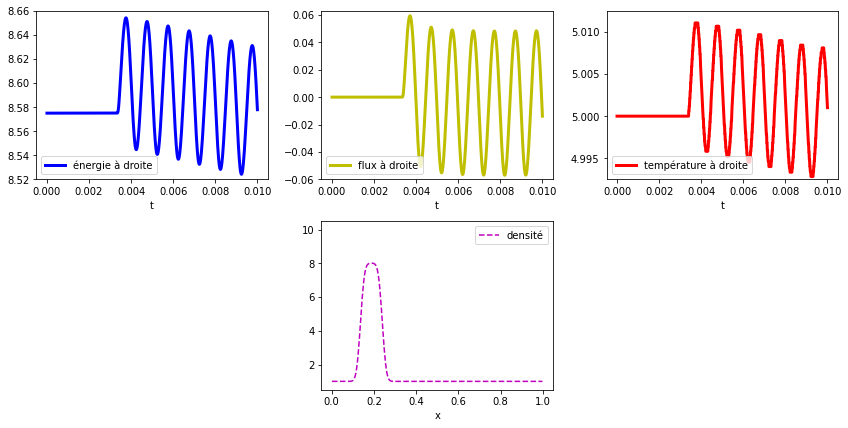

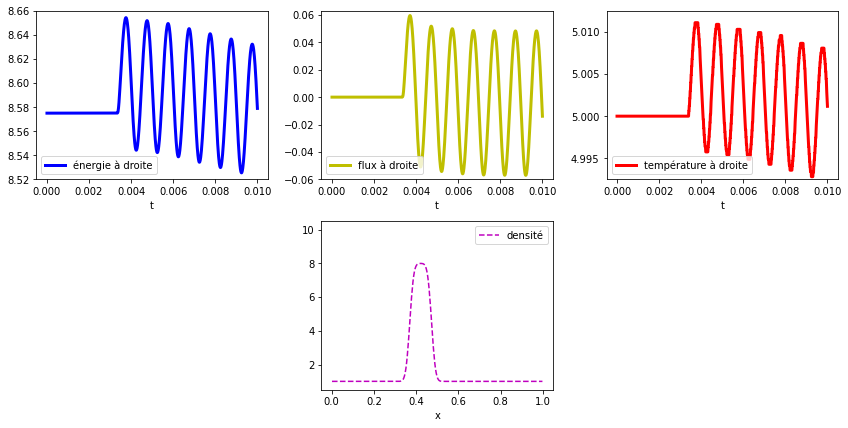

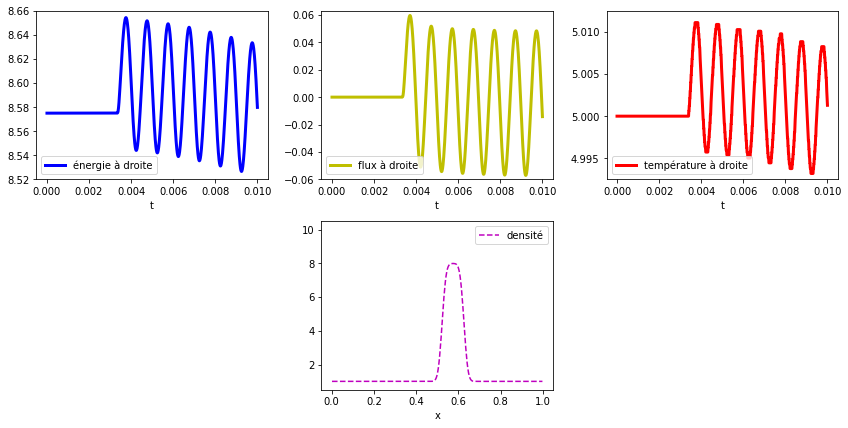

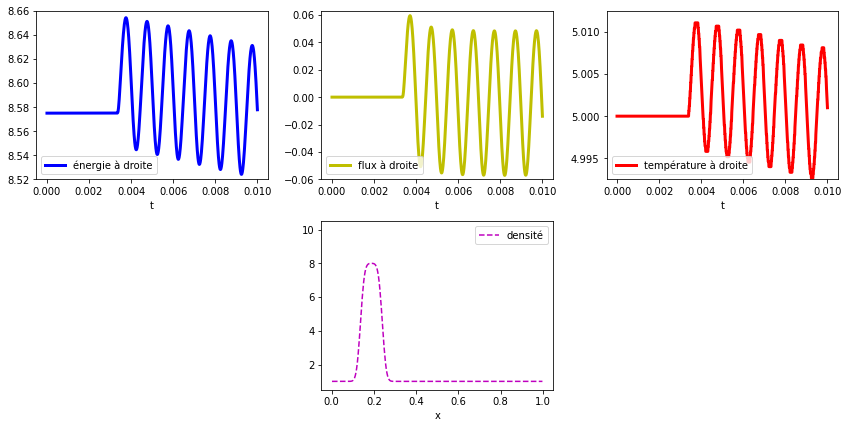

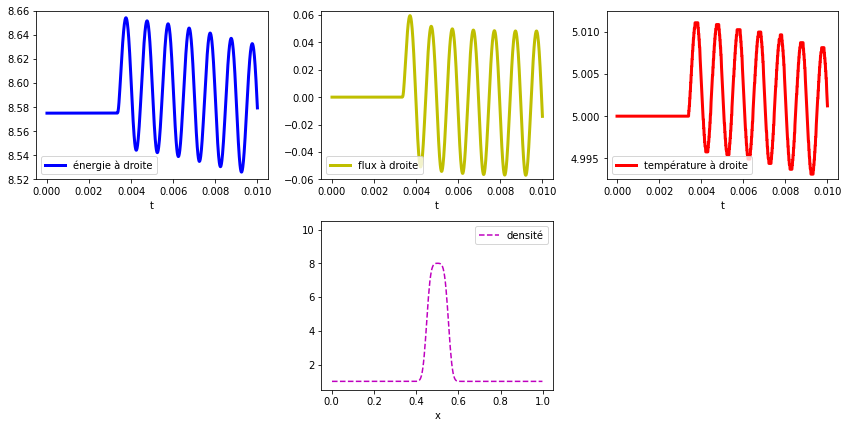

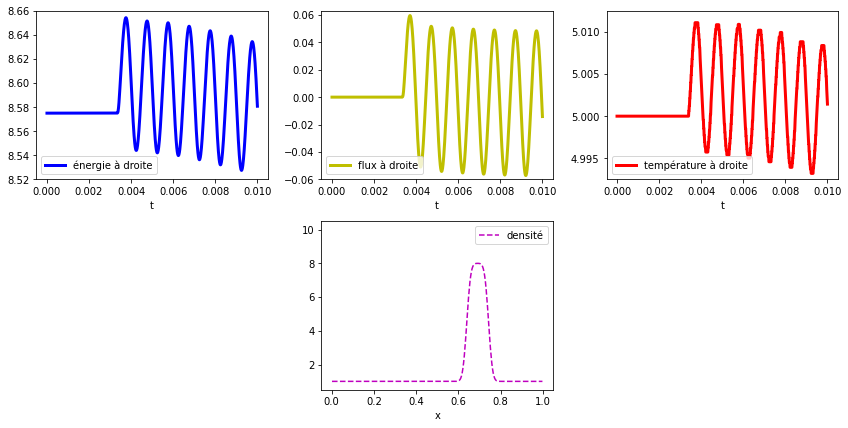

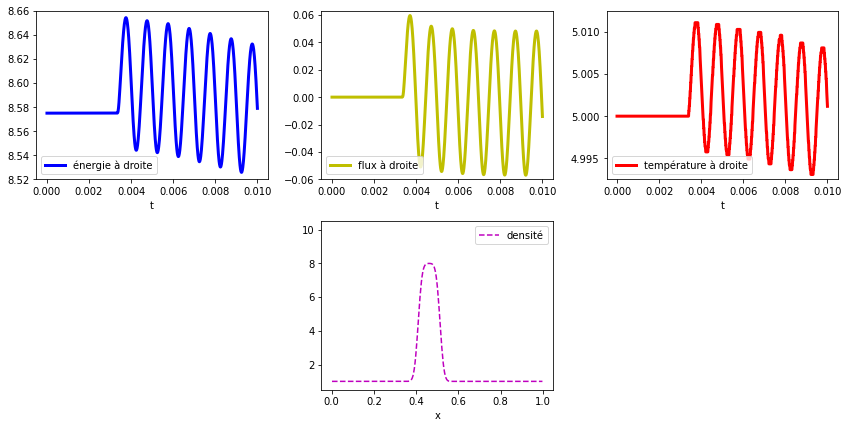

In [ ]:
""" Pour un saut de densite constant """
index = [89, 298, 1142, 1544, 2060, 2223, 2384, 2755, 2765, 3032]       # crenau = 8.0
# index = [562, 994, 1010, 1354, 1924, 2263, 2506, 2520, 2555]          # crenau = 9.5
# index = [579, 657, 672, 687, 864, 1457, 1790, 1984, 2259, 2294, 2372]   # crenau = 3.8

for i in index[:]:
  plot_io(i)

In [ ]:
# """ Plot position de la bosse ---> debut des oscillations, maximum du signal, minimum du signal """
# def plot_niche_position(index, title):
#   # les position des bosses
#   pos_niche = []
#   for i in index:
#     x = np.array(df_s.loc[i, 'x'])
#     rho = np.array(df_s.loc[i, 'rho'])
#     niche = detect_niches(rho)[0]
#     pos_niche.append(x[niche[0]])

#   # debut des oscillations
#   epsilon = 2.2204460492503131e-13
#   start_E = []
#   start_F = []
#   start_T = []

#   # maximum du signal
#   max_E = []
#   max_F = []
#   max_T = []

#   # minimum du signal
#   min_E = []
#   min_F = []
#   min_T = []

#   for i in index:
#       t = np.array(df_t.loc[i, 't'])

#       E_r = np.array(df_t.loc[i, 'E_r'])
#       F_r = np.array(df_t.loc[i, 'F_r'])
#       T_r = np.array(df_t.loc[i, 'T_r'])

#       start_E.append([np.argmax(abs(E_r - E_r[0]) >= epsilon)])
#       start_F.append([np.argmax(abs(F_r - F_r[0]) >= epsilon)])
#       start_T.append([np.argmax(abs(T_r - T_r[0]) >= epsilon)])

#       max_E.append([np.argmax(E_r)])
#       max_F.append([np.argmax(F_r)])
#       max_T.append([np.argmax(T_r)])

#       min_E.append([np.argmin(E_r)])
#       min_F.append([np.argmin(F_r)])
#       # min_F.append(np.argmin(F_r))
#       min_T.append([np.argmin(T_r)])

#   # ordonnons le tout
#   sorted = np.argsort(pos_niche)
#   pos_niche = np.array(pos_niche)[sorted]

#   start_E = np.array(start_E)[sorted]
#   start_F = np.array(start_F)[sorted]
#   start_T = np.array(start_T)[sorted]

#   max_E = np.array(max_E)[sorted]
#   max_F = np.array(max_F)[sorted]
#   max_T = np.array(max_T)[sorted]

#   min_E = np.array(min_E)[sorted]
#   min_F = np.array(min_F)[sorted]
#   min_T = np.array(min_T)[sorted]

#   # faisons le plot
#   fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

#   # debut des oscillations
#   ax[0].plot(pos_niche, start_E, 'b*-', label="énergie")
#   ax[0].plot(pos_niche, start_F, 'yx-', label="flux")
#   ax[0].plot(pos_niche, start_T, 'ro-', label="température")
#   ax[0].set_xlabel('position du crénau')
#   ax[0].set_ylabel('itération')
#   ax[0].set_title("début des oscillations", size='x-large', y=1.02)
#   ax[0].legend()

#   # atteinte du maximum
#   ax[1].plot(pos_niche, max_E, 'b*-', label="énergie")
#   ax[1].plot(pos_niche, max_F, 'yx-', label="flux")
#   ax[1].plot(pos_niche, max_T, 'ro-', label="température")
#   ax[1].set_xlabel('position du crénau')
#   ax[1].set_ylabel('itération')
#   ax[1].set_title("maximum", size='x-large', y=1.02)
#   ax[1].legend()

#   # atteinte du minimum
#   ax[2].plot(pos_niche, min_E, 'b*-', label="énergie")
#   ax[2].plot(pos_niche, min_F, 'yx-', label="flux")
#   ax[2].plot(pos_niche, min_T, 'ro-', label="température")
#   ax[2].set_xlabel('position du crénau')
#   ax[2].set_ylabel('itération')
#   ax[2].set_title("minimum", size='x-large', y=1.02)
#   ax[2].legend()

#   plt.suptitle(title, y=1.05, size='xx-large')
#   plt.tight_layout()

In [ ]:
# """ Plot position de la bosse ---> debut des oscillations """ 
# index = [89, 298, 1142, 1544, 2060, 2223, 2384, 2755, 2765, 3032]       # crenau = 8.0
# plot_niche_position(index, "taille de la bosse = 8.0")

In [ ]:
# index = [562, 994, 1010, 1354, 1924, 2263, 2506, 2520, 2555]          # crenau = 9.5
# plot_niche_position(index, "taille de la bosse = 9.5")

In [ ]:
# index = [579, 657, 672, 687, 864, 1457, 1790, 1984, 2259, 2294, 2372]   # crenau = 3.8
# plot_niche_position(index, "taille de la bosse = 3.8")

## Création des inputs X

Pour chacun des signaux E_r, F_r et T_r, il faut tout d'abord:
- Tronquer le signal pour ne ne garder que la fin
- Reechantilloner le signal pour ne garder que 20, voir 50 pas de temps

In [ ]:
""" Permet de couper le debut du signal, parite toujours constante. Retourne la fraction de fin """
def trim(input, ratio):               # verifier que 0 < ratio < 1
    len_input = len(input)
    len_output = int(len_input*ratio)
    return input[len_input-len_output:]

""" Fonction pour extraire n pas d'iterations """
def resample(input, len_output):      # verifier que len_output < len_input
    len_input = len(input)
    output = []
    for i in np.arange(0, len_input, len_input/len_output):
        output.append(input[int(i)])
    return np.array(output)


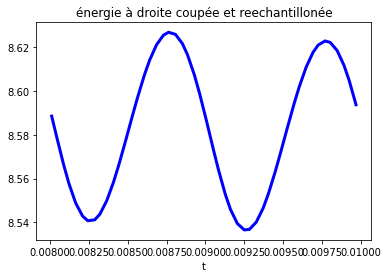

In [ ]:
""" Testons avec un exemple """
index = 0

t = np.array(df_t.loc[index, 't'])
E_r = np.array(df_t.loc[index, 'E_r'])

# ratio, len_X = 1, len(t)                    # on travaille avec TOUT du signal
# ratio, len_X = 2./3, 600                     # on travaille avec 2/3 (a la fin) sur 600 points
ratio, len_X = 0.2, 50                     # on travaille avec les 2/10 eme du signal sur 50 points seulement

t = resample(trim(t, ratio), len_X)
E_r = resample(trim(E_r, ratio), len_X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(t, E_r, 'b', lw=3)
ax.set_title('énergie à droite coupée et reechantillonée')
# ax.set_ylim(8.275, 8.875)
ax.set_xlabel('t');

In [ ]:
# """ Generation les inputs X """

# size = len(df_t)
# X = np.empty(shape=(size, 3, len_X), dtype=float)

# for i in range(size):
#     X[i][0] = resample(trim(df_t.loc[i, 'E_r'], ratio), len_X)
#     X[i][1] = resample(trim(df_t.loc[i, 'F_r'], ratio), len_X)
#     X[i][2] = resample(trim(df_t.loc[i, 'T_r'], ratio), len_X)
    
# print("X shape =", X.shape)

In [ ]:
""" Generation les inputs X sous forme transposee """
size = len(df_t)
X = np.empty(shape=(size, len_X, 3), dtype=float)

for i in range(size):
    X[i][:, 0] = resample(trim(df_t.loc[i, 'E_r'], ratio), len_X)
    X[i][:, 1] = resample(trim(df_t.loc[i, 'F_r'], ratio), len_X)
    X[i][:, 2] = resample(trim(df_t.loc[i, 'T_r'], ratio), len_X)
    
print("X shape =", X.shape)

X shape = (3053, 50, 3)


In [ ]:
# """ Applatissons les donnees avant de continuer """
# X = X.reshape([-1,3*len_X])

# print("flatten X shape =", X.shape)

## Creations des outputs y

Pour le signal de sortie $\rho$, il faut tout d'abord etre capable de detecter la position, la hauteur et la largeur de chaque saut de densite.

In [ ]:
""" Calcule les decalages a droite et a gauche d'un signal """
def decay(signal):
    signal_right = np.zeros_like(signal)
    signal_right[1:] = signal[:-1]
    signal_right[0] = signal[0]

    signal_left = np.zeros_like(signal)
    signal_left[:-1] = signal[1:]
    signal_left[-1] = signal[-1]
    
    return signal_left, signal_right

In [ ]:
""" Fonction de lissage laplacien 3-means d'un signal """
def smooth(signal):
    signal_left, signal_right = decay(signal)
    return (signal + signal_left + signal_right) / 3.

In [ ]:
""" Pour eliminer les tres tres faibles valeurs dans un signal """
def sharpen(signal, precision):
    return np.where(abs(signal) < precision, np.zeros_like(signal), signal)

In [ ]:
""" Une fonction pour detecter la position, hauteur et largeur des crenaux """
def detect_niches(signal):
    signal_left, signal_right = decay(signal)
    diff = -2*signal + signal_right + signal_left
    
    diff = sharpen(diff, 1e-4)
    
    # zero_crossings = []        # les points de traverse du 0
    niches = []                # les crenaux detectes
    
    prev = diff[0]
    next = diff[2]

    ended = False           # indique si on a retrouve la fin d'un crenau

    start = 1
    end = 1
    
    step = 1               # pas de recherche 
    i = step
    len_signal = len(diff)
    
    while i < len_signal-step:
        prev = diff[i-step]
        val = diff[i]
        next = diff[i+step]
    
        if prev > 0. and next < 0.:
            # zero_crossings.append(i)
            start = i
            ended = False

        if i == len_signal-step-1 and ended == False:
            prev = -1.
            next = 1.

        if prev < 0. and next > 0. and ended==False:
            # zero_crossings.append(i)
            end = i
    
            niche_width = end - start                 # largeur relative a N = len_signal
            niche_center = (end + start) // 2         # position relative a N
            niche_height = signal[niche_center]       # hauteur du crenaux

            niches.append((niche_center, niche_height, niche_width))

            ended = True
        
        # print(i, ended)
        # print(prev, next)

        i += 1
                
    return niches

In [ ]:
""" Pour afficher un signal et sa derivee seconde """
def plot_signal(ax, signal):
    signal_left, signal_right = decay(signal)
    diff = -2*signal + signal_right + signal_left

    diff = sharpen(diff, 1e-4)
    
    ax[0].plot(signal, 'm--', label='signal')
    ax[1].plot(diff[1:-1], 'c--', label='derivee seconde du signal');
    ax[0].legend()
    ax[1].legend()

Position, hauteur et largeur des créneaux detectés
 - (134, 5.0, 69)
 - (257, 2.804259852773157, 14)
 - (349, 9.999999999988198, 49)


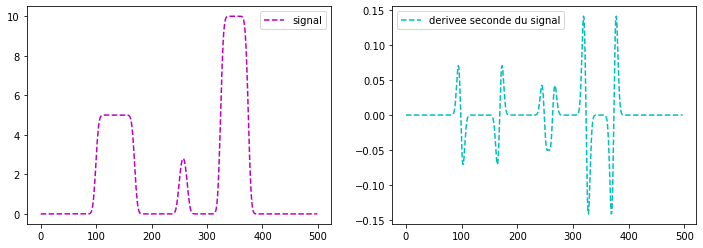

In [ ]:
""" Testons avec un exemple """
signal = np.zeros(500)

signal[100:170] = 5.         # ajout des crenaux
signal[250:265] = 3.
signal[325:375] = 10.

for i in range(25):          # lissage du signal
    signal = smooth(signal)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_signal(ax, signal)

niches = detect_niches(signal)

print("Position, hauteur et largeur des créneaux detectés")
for el in niches:
    print(" -", el)

In [ ]:
""" Testons sur un vrai "rho" (un qui provient de la dataframe) """
# index = 9
# signal = np.array(df_s.loc[index, 'rho'])
# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# plot_signal(ax, signal)

# niches = detect_niches(signal)
# for el in niches:
#     print(" -", el)

' Testons sur un vrai "rho" (un qui provient de la dataframe) '

In [ ]:
""" enfin on cree les y """
len_y = 2
y = np.empty(shape=(size, len_y), dtype=float)
bad_labels = []

for i in range(size):
    x = np.array(df_s.loc[i, 'x'])
    rho = np.array(df_s.loc[i, 'rho'])
    N = df_s.loc[i, 'N']
    dx = (x_max - x_min) / N   # xmin = 0, xmax = 1 bien sur. condition necessaire pour cette etude

    niches = detect_niches(rho)          
    niche = niches[0]                                           # on suppose qu'il ny a qu'un seul créneau 
    if len(niches) != 1 or niche[2] != int(0.1 * N):            # on veut juste les crenaux pleins (de largeur 30 (ou 50))
      bad_labels.append(i)
    
    y[i][0] = x[niche[0]]                     # position relative a x
    y[i][1] = niche[1]                  # hauteur
    # y[i][2] = niche[2]*dx                     # largeur (si nécessaire)
    
    # print(i, niche)
    # print(i, y[i])

print("y shape =", np.shape(y))

y shape = (3053, 2)


In [ ]:
""" Verifions que la position influence bien les resultats """
index = []

for i in range(size):
  # if y[i,0] > 0.8 and abs(y[i,1] - 8) < 0.01 :
  if abs(y[i,1] - 3.8) < 0.01 :
    index.append(i)

print("Quelques labels à observer:", index)

Quelques labels à observer: [579, 657, 672, 687, 864, 1457, 1790, 1984, 2259, 2294, 2372]


## Séparation des données train, test et val

In [ ]:
""" Vu qu'on ne predit pas la largeur, il faut suprimer tous les y qui ont une epaisseur != 0.1*N, ou qui ont plus d'un crenaux """

print("Mauvais labels pour l'apprentissage:", bad_labels)
print("Nombre de mauvais labels:", len(bad_labels))

# for i in bad_labels[:2]:
#   plot_io(i)

X = np.delete(X, bad_labels, axis=0)
y = np.delete(y, bad_labels, axis=0)

new_size = len(y)     # nouvelle taille ddes donnees dont on dispose
print("\nNouvelle taille des données:", new_size)

Mauvais labels pour l'apprentissage: [9, 10, 18, 22, 27, 45, 46, 61, 62, 63, 67, 69, 74, 81, 107, 109, 111, 113, 124, 133, 143, 148, 149, 156, 187, 190, 206, 209, 222, 226, 237, 250, 269, 275, 285, 292, 296, 305, 306, 327, 332, 344, 348, 365, 366, 368, 369, 374, 391, 393, 406, 435, 447, 452, 460, 461, 471, 473, 477, 484, 521, 545, 550, 556, 581, 584, 609, 642, 645, 653, 665, 685, 703, 714, 728, 732, 747, 763, 778, 780, 786, 796, 799, 806, 818, 819, 836, 860, 876, 879, 881, 890, 891, 903, 942, 952, 975, 977, 993, 1001, 1004, 1034, 1042, 1073, 1079, 1081, 1085, 1103, 1104, 1109, 1113, 1119, 1131, 1146, 1158, 1202, 1245, 1248, 1256, 1269, 1294, 1307, 1323, 1400, 1402, 1445, 1484, 1511, 1515, 1517, 1518, 1519, 1523, 1525, 1560, 1578, 1579, 1629, 1661, 1664, 1669, 1679, 1696, 1705, 1708, 1715, 1716, 1725, 1733, 1774, 1786, 1804, 1878, 1882, 1894, 1949, 1950, 1958, 2013, 2020, 2024, 2038, 2080, 2092, 2135, 2151, 2154, 2279, 2282, 2298, 2353, 2368, 2430, 2447, 2476, 2509, 2559, 2562, 2568, 25

In [ ]:
""" Une fonction pour detecter le min et le max d'un tenseur en excluant les NaN """
def min_max(mat, dim=2):
  mat_min = mat
  for i in range(dim-1, -1, -1):
      mat_min = np.nanmin(mat_min, axis=i)
      
  mat_max = mat
  for i in range(dim-1, -1, -1):
      mat_max = np.nanmax(mat_max, axis=i)

  return mat_min, mat_max

""" On fait une simple normalisation des donnnees. Division par le maximum de valeur absolue de sur chaque canal de X """
min_E, max_E = min_max(np.abs(X[:, :, 0]), 2)
min_F, max_F = min_max(np.abs(X[:, :, 1]), 2)
min_T, max_T = min_max(np.abs(X[:, :, 2]), 2)

X[:, :, 0] = X[:, :, 0] / max_E
X[:, :, 1] = X[:, :, 1] / max_F
X[:, :, 2] = X[:, :, 2] / max_T

In [ ]:
# print(min_max(y[:,1], 1))

(1.04741, 9.99601)


In [ ]:
len_train, len_val = 2250, 500

X_train = X[:len_train]
X_val = X[len_train:len_train+len_val]
X_test = X[len_train+len_val:]

y_train = y[:len_train]
y_val = y[len_train:len_train+len_val]
y_test = y[len_train+len_val:]

print("X shapes =", np.shape(X_train), np.shape(X_val), np.shape(X_test))
print("y shapes =", np.shape(y_train), np.shape(y_val), np.shape(y_test))

X shapes = (2250, 50, 3) (500, 50, 3) (117, 50, 3)
y shapes = (2250, 2) (500, 2) (117, 2)


In [ ]:
""" Sauvegarde de ce jeu de donnees pour un prochain apprentissage """
# np.save("train.npy", y_train)
# np.save("val.npy", y_val)
# np.save("test.npy", y_test)

' Sauvegarde de ce jeu de donnees pour un prochain apprentissage '

# APPRENTISSAGE

## Configuration du modèle 

In [ ]:
# """ Le modele s'appelle: Density Reconstruction Neural Network ^^ """ 

# model = keras.models.Sequential(name="DRNN")

# # model.add(keras.layers.Flatten(input_shape=(3, len_X)))

# # model.add(keras.layers.Dense(256, activation='relu', input_shape=(3*len_X,)))
# # model.add(keras.layers.Dense(256, activation='relu', input_shape=(3, len_X), activity_regularizer=keras.regularizers.l2(0.01)))
# model.add(keras.layers.Dense(256, activation='relu', input_shape=(3, len_X)))
# # model.add(keras.layers.Dense(256, activation='relu'))

# # ajouter la penalisation l2

# # model.add(keras.layers.Dropout(0.3))

# # model.add(keras.layers.Dense(64, activation='relu'))

# # model.add(keras.layers.Dropout(0.3))

# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(len_y, activation='linear'))

# """ Vérifions les parametres du modele """
# model.summary()

# # print("\nInfos supplémentaires")
# # for index in [0, 1, 2]:
# #     print("---------------------------")
# #     weights, bias = model.layers[index].get_weights()
# #     print("layer:", index)
# #     print("weights shape:", weights.shape)
# #     print("bias shape:", bias.shape)

In [ ]:
""" Un modèle convolutif """

model = models.Sequential(name="DRNN_1D")

model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(len_X, 3)))
model.add(layers.Conv1D(32, 3, activation='relu'))

# model.add(layers.MaxPooling1D())

model.add(layers.Conv1D(64,3, activation='relu'))
model.add(layers.Conv1D(64,3, activation='relu'))

# model.add(layers.MaxPooling1D())

model.add(layers.Conv1D(128,  3, activation='relu'))
model.add(layers.Conv1D(128,  3, activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(len_y, activation='linear'))

model.summary()

Model: "DRNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 32)            320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 32)            3104      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 42, 64)            12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 40, 128)           24704     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 38, 128)           49280     
_________________________________________________________________
flatten (Flatten)            (None, 4864)              0   

Pour la compilation:
- on utlise l'optimiseur Adam
- on utlise la `mse` pour fonction loss
- on observe l'accuracy: le cosinus de l'angle entre predictions et labels

In [ ]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=-1) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4), 
              loss=keras.losses.mse,
              # metrics=[keras.metrics.AUC()]
              # metrics=[keras.metrics.mean_absolute_error]
              # metrics=[keras.metrics.mean_absolute_percentage_error]
              metrics=[r2_score]
              )

In [ ]:
""" Pour une decroissance du taux d'apprentissage """

def scheduler(epoch, lr):
  if epoch >= 0:
    return 0.002
  else:
    return 0.95 * lr

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor="r2_score", mode="max", restore_best_weights=True)],
                    validation_data=(X_val, y_val))

Epoch 1/100
71/71 [==============================] - 1s 17ms/step - loss: 8.2574 - r2_score: 0.0722 - val_loss: 2.7594 - val_r2_score: 0.5358
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 1.4902 - r2_score: 0.7572 - val_loss: 0.0842 - val_r2_score: 0.9875
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0541 - r2_score: 0.9911 - val_loss: 0.0375 - val_r2_score: 0.9938
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0361 - r2_score: 0.9940 - val_loss: 0.0313 - val_r2_score: 0.9947
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0328 - r2_score: 0.9944 - val_loss: 0.0319 - val_r2_score: 0.9941
Epoch 6/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0326 - r2_score: 0.9943 - val_loss: 0.0305 - val_r2_score: 0.9945
Epoch 7/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0318 - r2_score: 0.9944 - val_loss: 0.0308 - val_r2_score: 0.9944
Epoch 8/100


In [ ]:
# """ Pour charger le modele """
# from google.colab import drive
# drive.mount('/gdrive')

# %cd ~
# %cd /gdrive/My\ Drive
# %cd Colab\ Notebooks/Projet\ inverse/1D
# print()

# %ls

In [ ]:
# # """ Chargeons le modele """
# model = keras.models.load_model("DRNN_1D.h5", custom_objects={"r2_score": r2_score}, compile=False)
# model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=keras.losses.mse, metrics=[r2_score])

Verifions le taux d'apprentissage final.

In [ ]:
""" devrait donner 0.002 * 0.95^20 """
round(model.optimizer.lr.numpy(), 5)

1e-04

Observons la decroissance de la loss

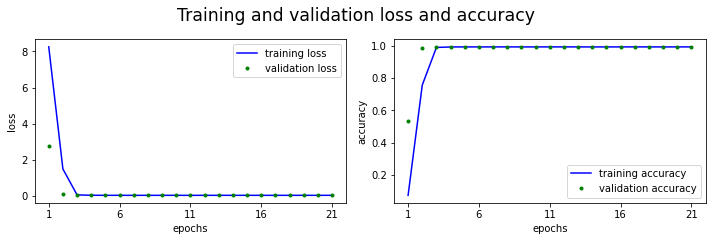

In [ ]:
history_dict = history.history
# print(history_dict.keys(), '\n')

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history_dict['r2_score']
val_acc = history_dict['val_r2_score']

epochs = range(1, len(loss)+1)
ticks = range(1, len(loss)+1, 5)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')
# ax0.set_ylim(0, 0.3)
ax0.set_xticks(ticks)
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xticks(ticks)
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

In [ ]:
""" Sauvegardons les bons modeles qu'on obtient """
# model.save('DRNN_1D.h5')

" Sauvegardons les bons modeles qu'on obtient "

## Quelques predictions

In [ ]:
hat_y_test = model.predict(X_test)

In [ ]:
def print_prediction(hat_y_test, nb):
  start = len_train + len_val    #indique le debut des donnes test la dataframe
  for i in range(0, new_size-start, (new_size-start)//nb):
    # print("index =", i + start)
    print("label:     ", y_test[i])
    print("prediction:", hat_y_test[i], "\n")

print_prediction(hat_y_test, 10)

label:      [0.548 5.847]
prediction: [0.523 5.814] 

label:      [0.632 1.298]
prediction: [0.484 1.294] 

label:      [0.545 2.803]
prediction: [0.488 2.793] 

label:      [0.262 2.744]
prediction: [0.487 2.73 ] 

label:      [0.112 3.675]
prediction: [0.495 3.658] 

label:      [0.475 7.867]
prediction: [0.523 7.828] 

label:      [0.448 9.206]
prediction: [0.513 9.183] 

label:      [0.312 5.642]
prediction: [0.522 5.599] 

label:      [0.222 1.664]
prediction: [0.488 1.645] 

label:      [0.588 8.419]
prediction: [0.519 8.383] 

label:      [0.205 4.842]
prediction: [0.512 4.783] 



In [ ]:
""" Le score r2 d'apres Keras """

print("r2 score on predictions: %.2f"%(100*model.evaluate(X_test, y_test)[1]), "%")

4/4 [==============================] - 0s 3ms/step - loss: 0.0295 - r2_score: 0.9952
r2 score on predictions: 99.52 %


Deffinissons une mesure d'accuracy. 

On suppose la prediction correcte si elle est suffisament proche du label:
- au **dizième** près pour la position
- à l'**unité** près pour la hauteur 

In [ ]:
""" Calculons l'accuracy """

condition1 = (abs(y_test[:, 0] - hat_y_test[:, 0]) <= .1)         # postition
condition2 = (abs(y_test[:, 1] - hat_y_test[:, 1]) <= 1)          # hauteur

acc_pos = 100 * len(hat_y_test[condition1]) / len(hat_y_test)
acc_hgt = 100 * len(hat_y_test[condition2]) / len(hat_y_test)
acc = 100 * len(hat_y_test[condition1 & condition2]) / len(hat_y_test)

print("position accuracy: %.2f"%acc_pos, "%")
print("height accuracy:   %.2f"%acc_hgt, "%")
print()
print("total accuracy:    %.2f"%acc, "%")

position accuracy: 25.64 %
height accuracy:   100.00 %

total accuracy:    25.64 %


## Les pires predictions

In [ ]:
def norm(vec):
  return np.sqrt(vec[0]**2 + (vec[1]/10)**2)

def norm2(vec):
  return np.sqrt(vec[1]**2)

def print_worst(norm):
  worst = [norm(y_test[i] - hat_y_test[i]) for i in range(len(X_test))]
  worst_index = np.flip(np.argsort(worst))

  print(worst_index[:10])
  print()
  for i in worst_index[:10]:
    print("label", y_test[i], "    prediction", hat_y_test[i])

""" On tient compte de tout """
print_worst(norm)

[ 21 116 102  34  45  57  80  43  54  44]

label [0.088 7.847]     prediction [0.521 7.732]
label [0.092 4.935]     prediction [0.512 4.879]
label [0.098 9.647]     prediction [0.508 9.521]
label [0.125 5.886]     prediction [0.522 5.849]
label [0.885 2.298]     prediction [0.49  2.286]
label [0.112 4.401]     prediction [0.506 4.375]
label [0.122 9.   ]     prediction [0.512 8.969]
label [0.118 4.242]     prediction [0.503 4.224]
label [0.132 8.508]     prediction [0.516 8.479]
label [0.112 3.675]     prediction [0.495 3.658]


In [ ]:
""" On tient compte uniquement de la position """
print_worst(norm2)

[ 14 102   3  21  46  41 114  68 109  82]

label [0.715 9.934]     prediction [0.507 9.796]
label [0.098 9.647]     prediction [0.508 9.521]
label [0.302 9.987]     prediction [0.504 9.864]
label [0.088 7.847]     prediction [0.521 7.732]
label [0.148 9.919]     prediction [0.505 9.804]
label [0.305 9.86 ]     prediction [0.507 9.762]
label [0.192 8.428]     prediction [0.518 8.342]
label [0.212 6.472]     prediction [0.525 6.389]
label [0.782 9.941]     prediction [0.505 9.863]
label [0.188 5.448]     prediction [0.519 5.378]


## Les meilleures predictions

In [ ]:
def print_best(norm):
  best = [norm(y_test[i] - hat_y_test[i]) for i in range(len(X_test))]
  best_index = np.argsort(best)

  print(best_index[:5])
  print()
  for i in best_index[:5]:
    print("label", y_test[i], "    prediction", hat_y_test[i])

In [ ]:
""" On tient compte de tout """
print_best(norm)

[86 64 76 63 58]

label [0.512 8.913]     prediction [0.514 8.89 ]
label [0.522 6.032]     prediction [0.524 6.001]
label [0.512 7.749]     prediction [0.523 7.707]
label [0.512 7.376]     prediction [0.525 7.337]
label [0.502 8.29 ]     prediction [0.519 8.253]


In [ ]:
""" On tient compte uniquement de la position """
print_best(norm2)

[84 13  5 29 11]

label [0.818 6.331]     prediction [0.526 6.332]
label [0.825 6.037]     prediction [0.525 6.034]
label [0.815 1.996]     prediction [0.49  1.998]
label [0.892 8.195]     prediction [0.522 8.198]
label [0.632 1.298]     prediction [0.484 1.294]


## Illustration des correlations

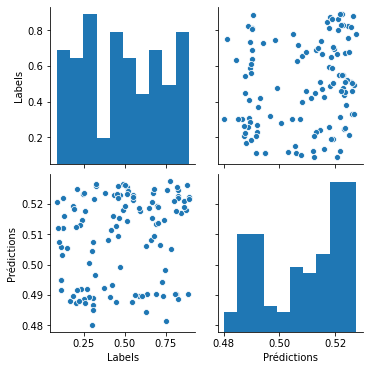

In [ ]:
""" La position """
df = pd.DataFrame({"Labels":y_test[:, 0]})
df["Prédictions"] = hat_y_test[:, 0]

sb.pairplot(df)

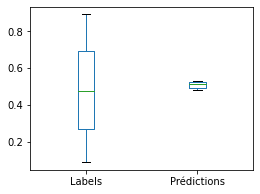

In [ ]:
""" La position """
ax = df.boxplot(column=["Labels", "Prédictions"], return_type='axes', figsize=(4,3), grid=False)

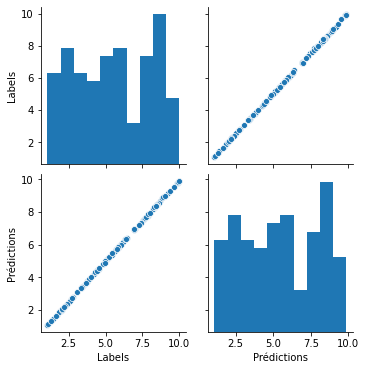

In [ ]:
""" La hauteur du crenau  """
df = pd.DataFrame({"Labels":y_test[:, 1]})
df["Prédictions"] = hat_y_test[:, 1]

sb.pairplot(df)

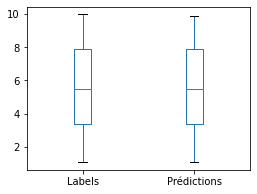

In [ ]:
""" La hauteur du crenau  """
ax = df.boxplot(column=["Labels", "Prédictions"], return_type='axes', figsize=(4,3), grid=False)